In [1]:
#libraries
import numpy as np
import imageio.v2 as io
import os
from tomopy.recon.algorithm import recon
from tomopy.recon.rotation import write_center as c_o_r
from tomopy.recon.rotation import find_center
from tomopy import circ_mask
from tomopy import minus_log
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from skimage.filters import median
from skimage.morphology import cube
from algotom.prep.correction import beam_hardening_correction as bhc
import algotom.rec.reconstruction as rec
import astra
logging.basicConfig(level=logging.INFO)


#### Step 1 - Nomalise the projections with darks and flats

In [2]:
# load projection data from tiffs in folder
path = 'J:/recon_4scott/21_ILL_SP_before_15mm_15s/Proj'
proj_arr = []
for i in os.listdir(path):
    proj = io.imread(path+'/'+i)
    proj_arr.append(proj)
proj_arr = np.array(proj_arr)[:,700:1200,200:1900]

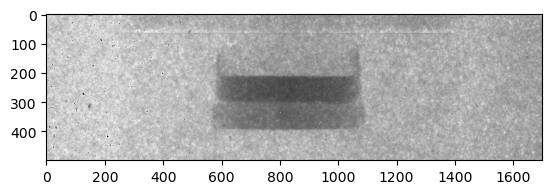

In [3]:
plt.imshow((proj_arr[250]*30).astype(np.uint16), cmap = 'gray')
plt.show()

In [4]:
# load flat and dark
# flat and dark averaging (mean)
# multiple flats and darks are averaged so that variation is taken into account when correction is applied
path_f = 'J:/recon_4scott/20_flats_15mmPinhole_15s'
flat_arr = []
for i in os.listdir(path_f):
    f = io.imread(path_f+'/'+i)
    flat_arr.append(f)
flat_arr = np.array(flat_arr)[:,700:1200,200:1900]
flat_arr = np.mean(flat_arr, 0)
io.imwrite('flat.tiff', flat_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

path_d = 'J:/recon_4scott/22_darks_15mm_15s'
dark_arr = []
for l in os.listdir(path_d):
    d = io.imread(path_d+'/'+l)
    dark_arr.append(d)
dark_arr = np.array(dark_arr)[:,700:1200,200:1900]
dark_arr = np.mean(dark_arr, 0)
io.imwrite('dark.tiff', dark_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

In [5]:
# apply normalisation and save to disk
# here dark flat correction is applied as... normed = (projection - dark_field) / (flat_field - dark_field) 
proj_normed = []
for i in tqdm(range(proj_arr.shape[0])):
    im = (proj_arr[i] - dark_arr)/(flat_arr - dark_arr)
    proj_normed.append(im)
proj_normed = np.array(proj_normed)
io.volwrite('normed_proj.tiff', proj_normed, format='tiff', bigtiff=True)

  0%|          | 0/1216 [00:00<?, ?it/s]C:\Users\matti\AppData\Local\Temp\ipykernel_16828\2182574200.py:5: RuntimeWarning: invalid value encountered in divide
  im = (proj_arr[i] - dark_arr)/(flat_arr - dark_arr)
100%|██████████| 1216/1216 [00:14<00:00, 84.68it/s]


In [6]:
# filter the white noise from the image
# normalise result between 0 - 1 range
proj_filt = median(proj_normed, cube(7))
proj_adapt = np.where(proj_normed - proj_filt > 0.12, proj_filt, proj_normed) # removes white noise without smoothing the remaining data (maybe useful...?)
proj_filt = np.nan_to_num(proj_filt)
proj_filt = proj_filt/np.amax(proj_filt)
io.volwrite('median_proj.tiff', proj_filt, format='tiff', bigtiff=True)
proj_adapt = np.nan_to_num(proj_adapt)
proj_adapt = proj_adapt/np.amax(proj_adapt)
io.volwrite('adapt_proj.tiff', proj_adapt, format='tiff', bigtiff=True)

### Step 2 - Define array of acquisition angles for each projection 

In [7]:
angle = 0 
angles = []
for j in range(1216):
    angles.append(angle)
    angle += (360/1215)
angles = np.array(angles)
angles = angles * (np.pi/180)

### Step 3 - Find the Centre of Roatation for the reconstruction 

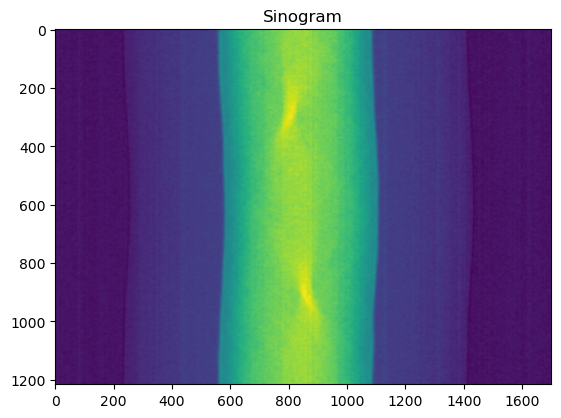

In [15]:
#plot sinogram
plt.imshow(minus_log(proj_filt[:, 350, :]))
plt.title('Sinogram')
plt.show()

In [16]:
# From sino we can see the CoR is roughly 830 
# also can see at lest one feature in this sino ... yay!
cor_finder = []
for centre in range(820, 840, 1):
    recon = rec.fbp_reconstruction(proj_filt[:,350,:], centre, angles, ratio=0.95, ramp_win=None, filter_name='hamming', pad=None, pad_mode='edge', apply_log=True, gpu=False, block=(16, 16), ncore=None)
    cor_finder.append(recon)
cor_finder = np.array(cor_finder)
io.volwrite('cor_finder.tiff', cor_finder, format='tiff')
# open this in imagej or whatever to view best CoR


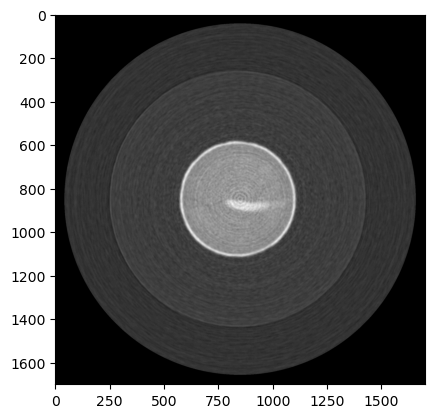

In [17]:
# plot result of CoR finding
plt.imshow(cor_finder[15], cmap = 'gray')
plt.show()

In [18]:
centre = 835.0

### Step 4 - Reconstruct the projections with FBP

In [19]:
# reconstruct the whole volume 
recon_fbp = rec.fbp_reconstruction(proj_filt, centre, angles, ratio=0.95, ramp_win=None, filter_name='hamming', apply_log=True, gpu=False, ncore=None)
io.volwrite('recon_fbp.tiff', recon_fbp, format='tiff', bigtiff=True)

C:\Users\matti\AppData\Roaming\Python\Python38\site-packages\algotom\rec\reconstruction.py:383: UserWarning: !!! Applying logarithm to sinogram is enabled but there are values <= 0.0 in the sinogram !!!
  warnings.warn("!!! Applying logarithm to sinogram is enabled but "


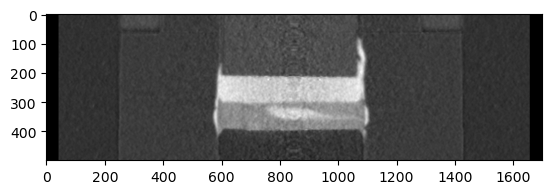

In [20]:
# plot result
plt.imshow(recon_fbp[870,:,:], cmap = 'gray')
plt.show()

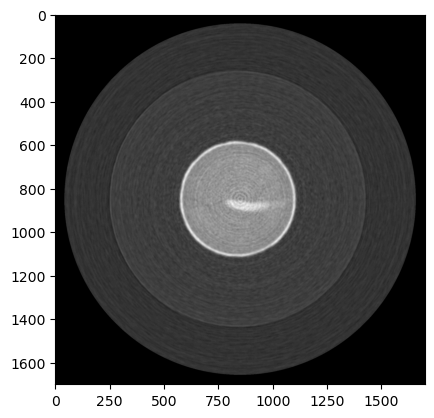

In [21]:
# plot result
plt.imshow(recon_fbp[:,350,:], cmap = 'gray')
plt.show()

### TO DO - Step 5 - Optimisation (different filters, ring removal, etc...)